# ===========================================================
# Solve the estimation problem with neural network tower model on the supervised dataset from the Jeopardy-like logs
# ===========================================================

Goals:
1. Split the data into test and train
2. Formulate the neural network based model
3. Compute train and test error

#### Last update: 12 Dec 2019

# Imports

In [2]:
from __future__ import division, print_function, absolute_import, unicode_literals

import scipy as sp
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import sys
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, LSTM, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras import regularizers

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report

sys.path.insert(0, '../src/')
%matplotlib inline

import utils
from mytimer import Timer

# Parameters

In [3]:
data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data_with_only_first_influence.pk'
# data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data_roberta.pk'
test_fraction = 0.15
runs = 10

# Helper functions

In [4]:
def get_influence_on_others(A: np.ndarray, index: int) -> float:
    A = np.array(A)
    return sum(
        A[[i for i in range(len(A))
           if i != index], index])

In [5]:
def get_eigvec_of_laplacian(A: np.matrix) -> np.matrix:
#     D = np.diag(np.array(np.sum(A, axis=0))[0])
#     L = D - A
#     return np.matrix(np.linalg.eig(L)[1])
    n, m = A.shape
    diags = A.sum(axis=1).flatten()
    D = sp.sparse.spdiags(diags, [0], m, n, format='csr')
    L = D - A
    with sp.errstate(divide='ignore'):
        diags_sqrt = 1.0/sp.sqrt(diags)
    diags_sqrt[sp.isinf(diags_sqrt)] = 0
    DH = sp.sparse.spdiags(diags_sqrt, [0], m, n, format='csr')
    DH = DH.todense()
    normalized_L = DH.dot(L.dot(DH))
    return normalized_L

## Models

In [6]:
def my_logistic_regression(X_train, X_test, y_train, y_test):
    lr = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000).fit(
        X_train, y_train)
    y_pred = lr.predict(X_test)
    return accuracy_score(y_test, y_pred)

def my_dummy_stratified(X_train, X_test, y_train, y_test):
    dummy_stratified = DummyClassifier(strategy='stratified').fit(
        X_train, y_train)
    y_pred = dummy_stratified.predict(X_test)
    return accuracy_score(y_test, y_pred)

def my_dummy_uniform(X_train, X_test, y_train, y_test):
    dummy_uniform = DummyClassifier(strategy='uniform').fit(
        X_train, y_train)
    y_pred = dummy_uniform.predict(X_test)
    return accuracy_score(y_test, y_pred)

def my_dummy_most_frequent(X_train, X_test, y_train, y_test):
    dummy_most_freq = DummyClassifier(strategy='most_frequent').fit(
        X_train, y_train)
    y_pred = dummy_most_freq.predict(X_test)
    return accuracy_score(y_test, y_pred)

def my_fc_nn(X_train, X_test, y_train, y_test, lambda1 = 0.01, epochs=400, batch_size=16):
    one_hot_y_train = []
    for sample in y_train:
        label = np.zeros(4)
        label[sample] = 1
        one_hot_y_train.append(label)
    one_hot_y_train = np.array(one_hot_y_train)

    input_dim = X_train.shape[1]
    model = Sequential([
        Dense(64,
              kernel_initializer='he_normal',
              activation='relu',
              input_shape=(input_dim,),
              kernel_regularizer=regularizers.l2(lambda1),
              activity_regularizer=regularizers.l1(lambda1)),
    #     Dropout(0.5),
    #     Dense(32,
    #           kernel_initializer='he_normal',
    #           activation='relu',
    #           kernel_regularizer=regularizers.l2(0.01),
    #           activity_regularizer=regularizers.l1(0.01)),
    #     Dropout(0.5),
        Dense(4, kernel_initializer='he_normal', activation='softmax')])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, one_hot_y_train, epochs=epochs, batch_size=batch_size)

    test_predicted = model.predict(X_test)
    model_y_pred = [np.argmax(predicted) for predicted in test_predicted]
    return accuracy_score(y_test, model_y_pred)

def my_conv_nn(X_train, X_test, y_train, y_test, lambda1 = 0.01, epochs=400, batch_size=16):
    one_hot_y_train = []
    for sample in y_train:
        label = np.zeros(4)
        label[sample] = 1
        one_hot_y_train.append(label)
    one_hot_y_train = np.array(one_hot_y_train)
    
    input_dim = X_train.shape[1]
    model2 = Sequential([
        Conv1D(
            32,
            2,
            kernel_initializer='he_normal',
            activation='relu',
            input_shape=(input_dim, 1),
            kernel_regularizer=regularizers.l1(lambda1),
            activity_regularizer=regularizers.l1(lambda1)),
        Conv1D(
            32,
            2,
            kernel_initializer='he_normal',
            activation='relu',
            kernel_regularizer=regularizers.l1(lambda1),
            activity_regularizer=regularizers.l1(lambda1)),
        MaxPooling1D(2),
        Conv1D(
            64,
            2,
            kernel_initializer='he_normal',
            activation='relu',
            kernel_regularizer=regularizers.l1(lambda1),
            activity_regularizer=regularizers.l1(lambda1)),
        Conv1D(
            64,
            2,
            kernel_initializer='he_normal',
            activation='relu',
            kernel_regularizer=regularizers.l1(lambda1),
            activity_regularizer=regularizers.l1(lambda1)),
        GlobalAveragePooling1D(),
        Dropout(0.5),
        Dense(
            units=4,
            kernel_initializer='he_normal',
            activation='softmax',
            kernel_regularizer=regularizers.l1(lambda1),
            activity_regularizer=regularizers.l1(lambda1))
    ])
    model2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model2.fit(
        np.reshape(X_train, (len(X_train), input_dim, 1)),
        one_hot_y_train,
        epochs=epochs,
        batch_size=batch_size)

    test_predicted = model2.predict(np.reshape(X_test, (len(X_test), input_dim, 1)))
    model2_y_pred = [np.argmax(predicted) for predicted in test_predicted]

    return accuracy_score(y_test, model2_y_pred)

In [140]:
def get_classification_dataset(data_X, data_y, only_one_influential_is_allowed=False):
    classification_data = {}
    classification_data['X'] = []
    classification_data['y'] = []

    for i in range(len(data_y)):
        influence_matrix = data_y[i]['influence_matrix']
        how_influential_one_is = [get_influence_on_others(influence_matrix, index)
                                  for index in range(4)]
        most_influentials = np.where(how_influential_one_is == max(how_influential_one_is))[0]
        if len(most_influentials) > 1 and only_one_influential_is_allowed:
            continue
        for most_influencial_index in most_influentials:

            # Labels.
            classification_data['y'].append(most_influencial_index)

            # Features: what to pick from raw features to be the features in classification data.
            raw_features = data_X[i]

            features = np.hstack(
                [np.array(raw_features['first_influence_matrices'].flatten())[0],
                 np.array(raw_features['reply_duration'].flatten())[0],
                 np.array(raw_features['sentiment'].flatten())[0],
#                  raw_features['content_embedding_matrix'].flatten(),
                 raw_features['individual_performance_hardness_weighted']])

    #         features = np.array(raw_features['reply_duration'].flatten())[0]

#             features = raw_features['content_embedding_matrix'].flatten()
#             features = np.array(raw_features['first_influence_matrices'].flatten())[0]


            classification_data['X'].append(features)
    classification_data['X'] = np.array(classification_data['X'])
    classification_data['y'] = np.array(classification_data['y'])
    return classification_data

# Loading the data

In [141]:
data = utils.load_it(data_fpath)
print(len(data['X']))

264


# Finding the most influential person
### Making the matrix estimation problem into multi class classification problem

In [142]:
X_train, X_test, y_train, y_test = train_test_split(
            data['X'],
            data['y'],
            test_size=test_fraction)
X_train, y_train = utils.replicate_networks_in_train_dataset_with_reordering(
    X_train, y_train)

In [143]:
training_data = get_classification_dataset(X_train, y_train)
X_train = training_data['X']
y_train = training_data['y']
testing_data = get_classification_dataset(X_test, y_test)
X_test = testing_data['X']
y_test = testing_data['y']

In [144]:
X_train.shape

(6354, 52)

In [145]:
lr = LogisticRegression(penalty='l1', max_iter=1000).fit(
    X_train, y_train)
y_pred = lr.predict(X_test)
print( classification_report(y_test, y_pred) )

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.53      0.56      0.54        18
           2       0.33      0.43      0.38        14
           3       0.57      0.36      0.44        11

   micro avg       0.46      0.46      0.46        50
   macro avg       0.48      0.44      0.46        50
weighted avg       0.48      0.46      0.46        50



In [146]:
accuracy_score(y_test, y_pred)

0.46

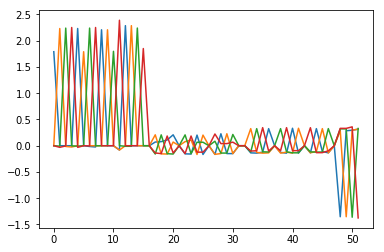

In [160]:
for i in range(4):
    plt.plot(lr.coef_[i])

# Classification

In [ ]:
classification_data = get_classification_dataset(data['X'], data['y'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
            classification_data['X'],
            classification_data['y'],
            test_size=test_fraction)

lr = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000).fit(
    X_train, y_train)
y_pred = lr.predict(X_test)
print( classification_report(y_test, y_pred) )

In [51]:
with Timer():
    models = [my_logistic_regression, my_dummy_stratified, my_dummy_uniform, my_dummy_most_frequent, my_fc_nn, my_conv_nn]

    accuracies = defaultdict(list)
    for run in range(runs):
        print('Run', run, ' ...')
        X_train, X_test, y_train, y_test = train_test_split(
            classification_data['X'],
            classification_data['y'],
            stratify = classification_data['y'],
            test_size=test_fraction)

        for model in models:
            accuracies[model.__name__].append(
                model(X_train, X_test, y_train, y_test))

Run 0  ...


/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 311 samples
Epoch 1/400
311/311 [==============================] - 0s 1ms/sample - loss: 1.8968 - accuracy: 0.7219
Epoch 2/400
311/311 [==============================] - 0s 125us/sample - loss: 1.4366 - accuracy: 0.7516
Epoch 3/400
311/311 [==============================] - 0s 122us/sample - loss: 1.1671 - accuracy: 0.7556
Epoch 4/400
311/311 [==============================] - 0s 110us/sample - loss: 0.9807 - accuracy: 0.7596
Epoch 5/400
311/311 [==============================] - 0s 111us/sample - loss: 0.8477 - accuracy: 0.7685
Epoch 6/400
311/311 [==============================] - 0s 102us/sample - loss: 0.7615 - accuracy: 0.7701
Epoch 7/400
311/311 [==============================] - 0s 109us/sample - loss: 0.6936 - accuracy: 0.7805
Epoch 8/400
311/311 [==============================] - 0s 106us/sample - loss: 0.6458 - accuracy: 0.7870
Epoch 9/400
311/311 [==============================] - 0s 118us/sample - loss: 0.6117 - accuracy: 0.7918
Epoch 10/400
311/311 [==============

311/311 [==============================] - 0s 99us/sample - loss: 0.3462 - accuracy: 0.8625
Epoch 156/400
311/311 [==============================] - 0s 99us/sample - loss: 0.3540 - accuracy: 0.8617
Epoch 157/400
311/311 [==============================] - 0s 95us/sample - loss: 0.3426 - accuracy: 0.8658
Epoch 158/400
311/311 [==============================] - 0s 101us/sample - loss: 0.3463 - accuracy: 0.8617
Epoch 159/400
311/311 [==============================] - 0s 99us/sample - loss: 0.3442 - accuracy: 0.8666
Epoch 160/400
311/311 [==============================] - 0s 97us/sample - loss: 0.3445 - accuracy: 0.8666
Epoch 161/400
311/311 [==============================] - 0s 100us/sample - loss: 0.3548 - accuracy: 0.8650
Epoch 162/400
311/311 [==============================] - 0s 94us/sample - loss: 0.3490 - accuracy: 0.8625
Epoch 163/400
311/311 [==============================] - 0s 95us/sample - loss: 0.3339 - accuracy: 0.8690
Epoch 164/400
311/311 [==============================] - 0

311/311 [==============================] - 0s 96us/sample - loss: 0.3581 - accuracy: 0.8553
Epoch 310/400
311/311 [==============================] - 0s 95us/sample - loss: 0.3716 - accuracy: 0.8545
Epoch 311/400
311/311 [==============================] - 0s 92us/sample - loss: 0.3608 - accuracy: 0.8593
Epoch 312/400
311/311 [==============================] - 0s 89us/sample - loss: 0.3463 - accuracy: 0.8617
Epoch 313/400
311/311 [==============================] - 0s 90us/sample - loss: 0.3497 - accuracy: 0.8625
Epoch 314/400
311/311 [==============================] - 0s 89us/sample - loss: 0.3400 - accuracy: 0.8633
Epoch 315/400
311/311 [==============================] - 0s 96us/sample - loss: 0.3346 - accuracy: 0.8666
Epoch 316/400
311/311 [==============================] - 0s 91us/sample - loss: 0.3373 - accuracy: 0.8641
Epoch 317/400
311/311 [==============================] - 0s 91us/sample - loss: 0.3272 - accuracy: 0.8682
Epoch 318/400
311/311 [==============================] - 0s 

311/311 [==============================] - 1s 2ms/sample - loss: 16.5938 - accuracy: 0.7500
Epoch 64/400
311/311 [==============================] - 1s 2ms/sample - loss: 16.0420 - accuracy: 0.7500
Epoch 65/400
311/311 [==============================] - 1s 2ms/sample - loss: 15.5190 - accuracy: 0.7500
Epoch 66/400
311/311 [==============================] - 1s 2ms/sample - loss: 15.0203 - accuracy: 0.7500
Epoch 67/400
311/311 [==============================] - 1s 2ms/sample - loss: 14.5447 - accuracy: 0.7500
Epoch 68/400
311/311 [==============================] - 1s 2ms/sample - loss: 14.0915 - accuracy: 0.7500
Epoch 69/400
311/311 [==============================] - 1s 2ms/sample - loss: 13.6599 - accuracy: 0.7500
Epoch 70/400
311/311 [==============================] - 1s 2ms/sample - loss: 13.2493 - accuracy: 0.7500
Epoch 71/400
311/311 [==============================] - 1s 2ms/sample - loss: 12.8585 - accuracy: 0.7500
Epoch 72/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 2ms/sample - loss: 1.8179 - accuracy: 0.7500
Epoch 220/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.8008 - accuracy: 0.7500
Epoch 221/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.7840 - accuracy: 0.7500
Epoch 222/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.7673 - accuracy: 0.7500
Epoch 223/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.7509 - accuracy: 0.7500
Epoch 224/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.7347 - accuracy: 0.7500
Epoch 225/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.7187 - accuracy: 0.7500
Epoch 226/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.7031 - accuracy: 0.7500
Epoch 227/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.6877 - accuracy: 0.7500
Epoch 228/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 2ms/sample - loss: 0.6771 - accuracy: 0.7500
Epoch 376/400
311/311 [==============================] - 1s 3ms/sample - loss: 0.6754 - accuracy: 0.7500
Epoch 377/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.6738 - accuracy: 0.7500
Epoch 378/400
311/311 [==============================] - 1s 3ms/sample - loss: 0.6722 - accuracy: 0.7500
Epoch 379/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.6706 - accuracy: 0.7500
Epoch 380/400
311/311 [==============================] - 1s 3ms/sample - loss: 0.6691 - accuracy: 0.7500
Epoch 381/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.6677 - accuracy: 0.7500
Epoch 382/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.6662 - accuracy: 0.7500
Epoch 383/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.6647 - accuracy: 0.7500
Epoch 384/400
311/311 [==============================] - 1s 2ms/sampl

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 311 samples
Epoch 1/400
311/311 [==============================] - 0s 1ms/sample - loss: 1.7272 - accuracy: 0.7355
Epoch 2/400
311/311 [==============================] - 0s 118us/sample - loss: 1.2783 - accuracy: 0.7532
Epoch 3/400
311/311 [==============================] - 0s 112us/sample - loss: 0.9874 - accuracy: 0.7556
Epoch 4/400
311/311 [==============================] - 0s 112us/sample - loss: 0.8098 - accuracy: 0.7613
Epoch 5/400
311/311 [==============================] - 0s 106us/sample - loss: 0.7013 - accuracy: 0.7685
Epoch 6/400
311/311 [==============================] - 0s 110us/sample - loss: 0.6334 - accuracy: 0.7765
Epoch 7/400
311/311 [==============================] - 0s 98us/sample - loss: 0.5845 - accuracy: 0.7958
Epoch 8/400
311/311 [==============================] - 0s 101us/sample - loss: 0.5561 - accuracy: 0.7958
Epoch 9/400
311/311 [==============================] - 0s 94us/sample - loss: 0.5297 - accuracy: 0.8014
Epoch 10/400
311/311 [================

311/311 [==============================] - 0s 93us/sample - loss: 0.2922 - accuracy: 0.9148
Epoch 156/400
311/311 [==============================] - 0s 99us/sample - loss: 0.2942 - accuracy: 0.9148
Epoch 157/400
311/311 [==============================] - 0s 91us/sample - loss: 0.2887 - accuracy: 0.9196
Epoch 158/400
311/311 [==============================] - 0s 94us/sample - loss: 0.3089 - accuracy: 0.9100
Epoch 159/400
311/311 [==============================] - 0s 92us/sample - loss: 0.3076 - accuracy: 0.9084
Epoch 160/400
311/311 [==============================] - 0s 91us/sample - loss: 0.3012 - accuracy: 0.9124
Epoch 161/400
311/311 [==============================] - 0s 91us/sample - loss: 0.2833 - accuracy: 0.9188
Epoch 162/400
311/311 [==============================] - 0s 110us/sample - loss: 0.2775 - accuracy: 0.9196
Epoch 163/400
311/311 [==============================] - 0s 115us/sample - loss: 0.2861 - accuracy: 0.9196
Epoch 164/400
311/311 [==============================] - 0

Epoch 309/400
311/311 [==============================] - 0s 107us/sample - loss: 0.2975 - accuracy: 0.9027
Epoch 310/400
311/311 [==============================] - 0s 127us/sample - loss: 0.3034 - accuracy: 0.8979
Epoch 311/400
311/311 [==============================] - 0s 101us/sample - loss: 0.2894 - accuracy: 0.9076
Epoch 312/400
311/311 [==============================] - 0s 102us/sample - loss: 0.2927 - accuracy: 0.9051
Epoch 313/400
311/311 [==============================] - 0s 104us/sample - loss: 0.2982 - accuracy: 0.9043
Epoch 314/400
311/311 [==============================] - 0s 103us/sample - loss: 0.3055 - accuracy: 0.9051
Epoch 315/400
311/311 [==============================] - 0s 109us/sample - loss: 0.3153 - accuracy: 0.8907
Epoch 316/400
311/311 [==============================] - 0s 109us/sample - loss: 0.2988 - accuracy: 0.8963
Epoch 317/400
311/311 [==============================] - 0s 102us/sample - loss: 0.3124 - accuracy: 0.8987
Epoch 318/400
311/311 [==============

311/311 [==============================] - 0s 92us/sample - loss: 0.2846 - accuracy: 0.9100
Epoch 387/400
311/311 [==============================] - 0s 90us/sample - loss: 0.2882 - accuracy: 0.9068
Epoch 388/400
311/311 [==============================] - 0s 95us/sample - loss: 0.2865 - accuracy: 0.9084
Epoch 389/400
311/311 [==============================] - 0s 89us/sample - loss: 0.2812 - accuracy: 0.9148
Epoch 390/400
311/311 [==============================] - 0s 90us/sample - loss: 0.2807 - accuracy: 0.9051
Epoch 391/400
311/311 [==============================] - 0s 99us/sample - loss: 0.2729 - accuracy: 0.9108
Epoch 392/400
311/311 [==============================] - 0s 95us/sample - loss: 0.2744 - accuracy: 0.9124
Epoch 393/400
311/311 [==============================] - 0s 98us/sample - loss: 0.2892 - accuracy: 0.9076
Epoch 394/400
311/311 [==============================] - 0s 98us/sample - loss: 0.2794 - accuracy: 0.9092
Epoch 395/400
311/311 [==============================] - 0s 

311/311 [==============================] - 1s 3ms/sample - loss: 3.8618 - accuracy: 0.7500
Epoch 142/400
311/311 [==============================] - 1s 3ms/sample - loss: 3.8233 - accuracy: 0.7500
Epoch 143/400
311/311 [==============================] - 1s 3ms/sample - loss: 3.7855 - accuracy: 0.7500
Epoch 144/400
311/311 [==============================] - 1s 3ms/sample - loss: 3.7483 - accuracy: 0.7500
Epoch 145/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.7117 - accuracy: 0.7500
Epoch 146/400
311/311 [==============================] - 1s 3ms/sample - loss: 3.6757 - accuracy: 0.7500
Epoch 147/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.6405 - accuracy: 0.7500
Epoch 148/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.6058 - accuracy: 0.7500
Epoch 149/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.5716 - accuracy: 0.7500
Epoch 150/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 3ms/sample - loss: 1.0290 - accuracy: 0.7500
Epoch 298/400
311/311 [==============================] - 1s 3ms/sample - loss: 1.0216 - accuracy: 0.7500
Epoch 299/400
311/311 [==============================] - 1s 3ms/sample - loss: 1.0142 - accuracy: 0.7500
Epoch 300/400
311/311 [==============================] - 1s 3ms/sample - loss: 1.0069 - accuracy: 0.7500
Epoch 301/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.9997 - accuracy: 0.7500
Epoch 302/400
311/311 [==============================] - 1s 3ms/sample - loss: 0.9927 - accuracy: 0.7500
Epoch 303/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.9858 - accuracy: 0.7500
Epoch 304/400
311/311 [==============================] - 1s 3ms/sample - loss: 0.9789 - accuracy: 0.7500
Epoch 305/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.9722 - accuracy: 0.7500
Epoch 306/400
311/311 [==============================] - 1s 3ms/sampl

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 311 samples
Epoch 1/400
311/311 [==============================] - 0s 1ms/sample - loss: 1.6895 - accuracy: 0.7484
Epoch 2/400
311/311 [==============================] - 0s 121us/sample - loss: 1.2230 - accuracy: 0.7500
Epoch 3/400
311/311 [==============================] - 0s 119us/sample - loss: 0.9186 - accuracy: 0.7500
Epoch 4/400
311/311 [==============================] - 0s 119us/sample - loss: 0.7521 - accuracy: 0.7516
Epoch 5/400
311/311 [==============================] - 0s 115us/sample - loss: 0.6627 - accuracy: 0.7532
Epoch 6/400
311/311 [==============================] - 0s 107us/sample - loss: 0.6132 - accuracy: 0.7605
Epoch 7/400
311/311 [==============================] - 0s 112us/sample - loss: 0.5817 - accuracy: 0.7677
Epoch 8/400
311/311 [==============================] - 0s 108us/sample - loss: 0.5670 - accuracy: 0.7725
Epoch 9/400
311/311 [==============================] - 0s 104us/sample - loss: 0.5559 - accuracy: 0.7741
Epoch 10/400
311/311 [==============

311/311 [==============================] - 0s 105us/sample - loss: 0.2750 - accuracy: 0.9220
Epoch 156/400
311/311 [==============================] - 0s 104us/sample - loss: 0.2654 - accuracy: 0.9220
Epoch 157/400
311/311 [==============================] - 0s 97us/sample - loss: 0.2534 - accuracy: 0.9268
Epoch 158/400
311/311 [==============================] - 0s 95us/sample - loss: 0.2577 - accuracy: 0.9268
Epoch 159/400
311/311 [==============================] - 0s 96us/sample - loss: 0.2553 - accuracy: 0.9212
Epoch 160/400
311/311 [==============================] - 0s 99us/sample - loss: 0.2681 - accuracy: 0.9220
Epoch 161/400
311/311 [==============================] - 0s 97us/sample - loss: 0.2753 - accuracy: 0.9180
Epoch 162/400
311/311 [==============================] - 0s 100us/sample - loss: 0.2652 - accuracy: 0.9236
Epoch 163/400
311/311 [==============================] - 0s 107us/sample - loss: 0.2732 - accuracy: 0.9204
Epoch 164/400
311/311 [==============================] -

311/311 [==============================] - 0s 100us/sample - loss: 0.2588 - accuracy: 0.9196
Epoch 233/400
311/311 [==============================] - 0s 97us/sample - loss: 0.2468 - accuracy: 0.9268
Epoch 234/400
311/311 [==============================] - 0s 93us/sample - loss: 0.2609 - accuracy: 0.9236
Epoch 235/400
311/311 [==============================] - 0s 100us/sample - loss: 0.2676 - accuracy: 0.9164
Epoch 236/400
311/311 [==============================] - 0s 100us/sample - loss: 0.2645 - accuracy: 0.9180
Epoch 237/400
311/311 [==============================] - 0s 97us/sample - loss: 0.2559 - accuracy: 0.9220
Epoch 238/400
311/311 [==============================] - 0s 97us/sample - loss: 0.2607 - accuracy: 0.9236
Epoch 239/400
311/311 [==============================] - 0s 100us/sample - loss: 0.2712 - accuracy: 0.9196
Epoch 240/400
311/311 [==============================] - 0s 96us/sample - loss: 0.2717 - accuracy: 0.9196
Epoch 241/400
311/311 [==============================] -

311/311 [==============================] - 0s 95us/sample - loss: 0.2435 - accuracy: 0.9260
Epoch 310/400
311/311 [==============================] - 0s 100us/sample - loss: 0.2427 - accuracy: 0.9277
Epoch 311/400
311/311 [==============================] - 0s 107us/sample - loss: 0.2405 - accuracy: 0.9277
Epoch 312/400
311/311 [==============================] - 0s 102us/sample - loss: 0.2324 - accuracy: 0.9293
Epoch 313/400
311/311 [==============================] - 0s 103us/sample - loss: 0.2310 - accuracy: 0.9285
Epoch 314/400
311/311 [==============================] - 0s 103us/sample - loss: 0.2283 - accuracy: 0.9285
Epoch 315/400
311/311 [==============================] - 0s 99us/sample - loss: 0.2263 - accuracy: 0.9268
Epoch 316/400
311/311 [==============================] - 0s 98us/sample - loss: 0.2293 - accuracy: 0.9252
Epoch 317/400
311/311 [==============================] - 0s 107us/sample - loss: 0.2370 - accuracy: 0.9277
Epoch 318/400
311/311 [==============================]

Epoch 386/400
311/311 [==============================] - 0s 98us/sample - loss: 0.2425 - accuracy: 0.9212
Epoch 387/400
311/311 [==============================] - 0s 97us/sample - loss: 0.2411 - accuracy: 0.9196
Epoch 388/400
311/311 [==============================] - 0s 94us/sample - loss: 0.2378 - accuracy: 0.9204
Epoch 389/400
311/311 [==============================] - 0s 95us/sample - loss: 0.2345 - accuracy: 0.9204
Epoch 390/400
311/311 [==============================] - 0s 100us/sample - loss: 0.2337 - accuracy: 0.9212
Epoch 391/400
311/311 [==============================] - 0s 99us/sample - loss: 0.2312 - accuracy: 0.9212
Epoch 392/400
311/311 [==============================] - 0s 98us/sample - loss: 0.2314 - accuracy: 0.9196
Epoch 393/400
311/311 [==============================] - 0s 97us/sample - loss: 0.2341 - accuracy: 0.9196
Epoch 394/400
311/311 [==============================] - 0s 97us/sample - loss: 0.2293 - accuracy: 0.9212
Epoch 395/400
311/311 [======================

311/311 [==============================] - 1s 2ms/sample - loss: 4.1429 - accuracy: 0.7500
Epoch 142/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.0999 - accuracy: 0.7500
Epoch 143/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.0572 - accuracy: 0.7500
Epoch 144/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.0151 - accuracy: 0.7500
Epoch 145/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.9737 - accuracy: 0.7500
Epoch 146/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.9329 - accuracy: 0.7500
Epoch 147/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.8925 - accuracy: 0.7500
Epoch 148/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.8526 - accuracy: 0.7500
Epoch 149/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.8130 - accuracy: 0.7500
Epoch 150/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 2ms/sample - loss: 1.0282 - accuracy: 0.7500
Epoch 298/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.0209 - accuracy: 0.7500
Epoch 299/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.0137 - accuracy: 0.7500
Epoch 300/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.0066 - accuracy: 0.7500
Epoch 301/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.9994 - accuracy: 0.7500
Epoch 302/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.9925 - accuracy: 0.7500
Epoch 303/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.9855 - accuracy: 0.7500
Epoch 304/400
311/311 [==============================] - 1s 3ms/sample - loss: 0.9787 - accuracy: 0.7500
Epoch 305/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.9719 - accuracy: 0.7500
Epoch 306/400
311/311 [==============================] - 1s 2ms/sampl

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 311 samples
Epoch 1/400
311/311 [==============================] - 0s 1ms/sample - loss: 1.7220 - accuracy: 0.7436
Epoch 2/400
311/311 [==============================] - 0s 104us/sample - loss: 1.2484 - accuracy: 0.7548
Epoch 3/400
311/311 [==============================] - 0s 98us/sample - loss: 0.9488 - accuracy: 0.7645
Epoch 4/400
311/311 [==============================] - 0s 108us/sample - loss: 0.7762 - accuracy: 0.7637
Epoch 5/400
311/311 [==============================] - 0s 100us/sample - loss: 0.6759 - accuracy: 0.7701
Epoch 6/400
311/311 [==============================] - 0s 97us/sample - loss: 0.6155 - accuracy: 0.7709
Epoch 7/400
311/311 [==============================] - 0s 94us/sample - loss: 0.5831 - accuracy: 0.7757
Epoch 8/400
311/311 [==============================] - 0s 95us/sample - loss: 0.5514 - accuracy: 0.7910
Epoch 9/400
311/311 [==============================] - 0s 97us/sample - loss: 0.5272 - accuracy: 0.7950
Epoch 10/400
311/311 [===================

311/311 [==============================] - 0s 98us/sample - loss: 0.2541 - accuracy: 0.9285
Epoch 156/400
311/311 [==============================] - 0s 95us/sample - loss: 0.2515 - accuracy: 0.9301
Epoch 157/400
311/311 [==============================] - 0s 92us/sample - loss: 0.2442 - accuracy: 0.9309
Epoch 158/400
311/311 [==============================] - 0s 108us/sample - loss: 0.2429 - accuracy: 0.9317
Epoch 159/400
311/311 [==============================] - 0s 98us/sample - loss: 0.2343 - accuracy: 0.9301
Epoch 160/400
311/311 [==============================] - 0s 99us/sample - loss: 0.2506 - accuracy: 0.9301
Epoch 161/400
311/311 [==============================] - 0s 107us/sample - loss: 0.2370 - accuracy: 0.9309
Epoch 162/400
311/311 [==============================] - 0s 103us/sample - loss: 0.2304 - accuracy: 0.9325
Epoch 163/400
311/311 [==============================] - 0s 104us/sample - loss: 0.2512 - accuracy: 0.9236
Epoch 164/400
311/311 [==============================] -

Epoch 232/400
311/311 [==============================] - 0s 97us/sample - loss: 0.2585 - accuracy: 0.9132
Epoch 233/400
311/311 [==============================] - 0s 99us/sample - loss: 0.2756 - accuracy: 0.9164
Epoch 234/400
311/311 [==============================] - 0s 97us/sample - loss: 0.2755 - accuracy: 0.9124
Epoch 235/400
311/311 [==============================] - 0s 97us/sample - loss: 0.2932 - accuracy: 0.9003
Epoch 236/400
311/311 [==============================] - 0s 99us/sample - loss: 0.2934 - accuracy: 0.9108
Epoch 237/400
311/311 [==============================] - 0s 99us/sample - loss: 0.2919 - accuracy: 0.9132
Epoch 238/400
311/311 [==============================] - 0s 96us/sample - loss: 0.2978 - accuracy: 0.9027
Epoch 239/400
311/311 [==============================] - 0s 96us/sample - loss: 0.3003 - accuracy: 0.9019
Epoch 240/400
311/311 [==============================] - 0s 102us/sample - loss: 0.2902 - accuracy: 0.9051
Epoch 241/400
311/311 [======================

Epoch 309/400
311/311 [==============================] - 0s 108us/sample - loss: 0.2418 - accuracy: 0.9188
Epoch 310/400
311/311 [==============================] - 0s 110us/sample - loss: 0.2395 - accuracy: 0.9204
Epoch 311/400
311/311 [==============================] - 0s 119us/sample - loss: 0.2362 - accuracy: 0.9252
Epoch 312/400
311/311 [==============================] - 0s 116us/sample - loss: 0.2456 - accuracy: 0.9204
Epoch 313/400
311/311 [==============================] - 0s 105us/sample - loss: 0.2573 - accuracy: 0.9164
Epoch 314/400
311/311 [==============================] - 0s 111us/sample - loss: 0.2757 - accuracy: 0.9116
Epoch 315/400
311/311 [==============================] - 0s 104us/sample - loss: 0.2757 - accuracy: 0.9132
Epoch 316/400
311/311 [==============================] - 0s 98us/sample - loss: 0.2857 - accuracy: 0.9051
Epoch 317/400
311/311 [==============================] - 0s 99us/sample - loss: 0.3093 - accuracy: 0.8947
Epoch 318/400
311/311 [================

311/311 [==============================] - 1s 2ms/sample - loss: 18.1252 - accuracy: 0.7500
Epoch 63/400
311/311 [==============================] - 1s 2ms/sample - loss: 17.5242 - accuracy: 0.7500
Epoch 64/400
311/311 [==============================] - 1s 2ms/sample - loss: 16.9497 - accuracy: 0.7500
Epoch 65/400
311/311 [==============================] - 1s 2ms/sample - loss: 16.4017 - accuracy: 0.7500
Epoch 66/400
311/311 [==============================] - 1s 2ms/sample - loss: 15.8783 - accuracy: 0.7500
Epoch 67/400
311/311 [==============================] - 1s 2ms/sample - loss: 15.3778 - accuracy: 0.7500
Epoch 68/400
311/311 [==============================] - 1s 2ms/sample - loss: 14.9001 - accuracy: 0.7500
Epoch 69/400
311/311 [==============================] - 1s 2ms/sample - loss: 14.4430 - accuracy: 0.7500
Epoch 70/400
311/311 [==============================] - 1s 2ms/sample - loss: 14.0059 - accuracy: 0.7500
Epoch 71/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 2ms/sample - loss: 1.7188 - accuracy: 0.7500
Epoch 219/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.7042 - accuracy: 0.7500
Epoch 220/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.6897 - accuracy: 0.7500
Epoch 221/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.6754 - accuracy: 0.7500
Epoch 222/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.6613 - accuracy: 0.7500
Epoch 223/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.6473 - accuracy: 0.7500
Epoch 224/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.6337 - accuracy: 0.7500
Epoch 225/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.6201 - accuracy: 0.7500
Epoch 226/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.6067 - accuracy: 0.7500
Epoch 227/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 2ms/sample - loss: 0.6950 - accuracy: 0.7500
Epoch 375/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.6930 - accuracy: 0.7500
Epoch 376/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.6909 - accuracy: 0.7500
Epoch 377/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.6889 - accuracy: 0.7500
Epoch 378/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.6869 - accuracy: 0.7500
Epoch 379/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.6849 - accuracy: 0.7500
Epoch 380/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.6830 - accuracy: 0.7500
Epoch 381/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.6812 - accuracy: 0.7500
Epoch 382/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.6793 - accuracy: 0.7500
Epoch 383/400
311/311 [==============================] - 1s 2ms/sampl

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 311 samples
Epoch 1/400
311/311 [==============================] - 0s 1ms/sample - loss: 1.7135 - accuracy: 0.7428
Epoch 2/400
311/311 [==============================] - 0s 135us/sample - loss: 1.2260 - accuracy: 0.7500
Epoch 3/400
311/311 [==============================] - 0s 135us/sample - loss: 0.9199 - accuracy: 0.7524
Epoch 4/400
311/311 [==============================] - 0s 120us/sample - loss: 0.7555 - accuracy: 0.7580
Epoch 5/400
311/311 [==============================] - 0s 121us/sample - loss: 0.6676 - accuracy: 0.7669
Epoch 6/400
311/311 [==============================] - 0s 101us/sample - loss: 0.6152 - accuracy: 0.7677
Epoch 7/400
311/311 [==============================] - 0s 95us/sample - loss: 0.5768 - accuracy: 0.7797
Epoch 8/400
311/311 [==============================] - 0s 97us/sample - loss: 0.5683 - accuracy: 0.7765
Epoch 9/400
311/311 [==============================] - 0s 94us/sample - loss: 0.5428 - accuracy: 0.7854
Epoch 10/400
311/311 [=================

311/311 [==============================] - 0s 101us/sample - loss: 0.3521 - accuracy: 0.8561
Epoch 156/400
311/311 [==============================] - 0s 100us/sample - loss: 0.3503 - accuracy: 0.8561
Epoch 157/400
311/311 [==============================] - 0s 100us/sample - loss: 0.3633 - accuracy: 0.8529
Epoch 158/400
311/311 [==============================] - 0s 97us/sample - loss: 0.3509 - accuracy: 0.8521
Epoch 159/400
311/311 [==============================] - 0s 99us/sample - loss: 0.3528 - accuracy: 0.8561
Epoch 160/400
311/311 [==============================] - 0s 99us/sample - loss: 0.3721 - accuracy: 0.8529
Epoch 161/400
311/311 [==============================] - 0s 96us/sample - loss: 0.3614 - accuracy: 0.8505
Epoch 162/400
311/311 [==============================] - 0s 99us/sample - loss: 0.3566 - accuracy: 0.8505
Epoch 163/400
311/311 [==============================] - 0s 102us/sample - loss: 0.3591 - accuracy: 0.8561
Epoch 164/400
311/311 [==============================] -

Epoch 232/400
311/311 [==============================] - 0s 102us/sample - loss: 0.3499 - accuracy: 0.8569
Epoch 233/400
311/311 [==============================] - 0s 97us/sample - loss: 0.3451 - accuracy: 0.8577
Epoch 234/400
311/311 [==============================] - 0s 107us/sample - loss: 0.3550 - accuracy: 0.8529
Epoch 235/400
311/311 [==============================] - 0s 101us/sample - loss: 0.3529 - accuracy: 0.8561
Epoch 236/400
311/311 [==============================] - 0s 94us/sample - loss: 0.3523 - accuracy: 0.8561
Epoch 237/400
311/311 [==============================] - 0s 97us/sample - loss: 0.3498 - accuracy: 0.8561
Epoch 238/400
311/311 [==============================] - 0s 97us/sample - loss: 0.3422 - accuracy: 0.8609
Epoch 239/400
311/311 [==============================] - 0s 100us/sample - loss: 0.3403 - accuracy: 0.8601
Epoch 240/400
311/311 [==============================] - 0s 94us/sample - loss: 0.3364 - accuracy: 0.8593
Epoch 241/400
311/311 [===================

311/311 [==============================] - 0s 105us/sample - loss: 0.3820 - accuracy: 0.8392
Epoch 385/400
311/311 [==============================] - 0s 102us/sample - loss: 0.3785 - accuracy: 0.8384
Epoch 386/400
311/311 [==============================] - 0s 101us/sample - loss: 0.3816 - accuracy: 0.8376
Epoch 387/400
311/311 [==============================] - 0s 98us/sample - loss: 0.3853 - accuracy: 0.8360
Epoch 388/400
311/311 [==============================] - 0s 106us/sample - loss: 0.3831 - accuracy: 0.8376
Epoch 389/400
311/311 [==============================] - 0s 106us/sample - loss: 0.3767 - accuracy: 0.8376
Epoch 390/400
311/311 [==============================] - 0s 103us/sample - loss: 0.3796 - accuracy: 0.8376
Epoch 391/400
311/311 [==============================] - 0s 104us/sample - loss: 0.3731 - accuracy: 0.8384
Epoch 392/400
311/311 [==============================] - 0s 108us/sample - loss: 0.3719 - accuracy: 0.8392
Epoch 393/400
311/311 [=============================

311/311 [==============================] - 1s 2ms/sample - loss: 4.2819 - accuracy: 0.7500
Epoch 140/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.2358 - accuracy: 0.7500
Epoch 141/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.1904 - accuracy: 0.7500
Epoch 142/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.1461 - accuracy: 0.7500
Epoch 143/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.1025 - accuracy: 0.7500
Epoch 144/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.0596 - accuracy: 0.7500
Epoch 145/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.0173 - accuracy: 0.7500
Epoch 146/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.9756 - accuracy: 0.7500
Epoch 147/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.9348 - accuracy: 0.7500
Epoch 148/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 2ms/sample - loss: 1.0383 - accuracy: 0.7500
Epoch 296/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.0310 - accuracy: 0.7500
Epoch 297/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.0237 - accuracy: 0.7500
Epoch 298/400
311/311 [==============================] - 1s 3ms/sample - loss: 1.0166 - accuracy: 0.7500
Epoch 299/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.0096 - accuracy: 0.7500
Epoch 300/400
311/311 [==============================] - 1s 3ms/sample - loss: 1.0026 - accuracy: 0.7500
Epoch 301/400
311/311 [==============================] - 1s 3ms/sample - loss: 0.9959 - accuracy: 0.7500
Epoch 302/400
311/311 [==============================] - 1s 3ms/sample - loss: 0.9893 - accuracy: 0.7500
Epoch 303/400
311/311 [==============================] - 1s 3ms/sample - loss: 0.9828 - accuracy: 0.7500
Epoch 304/400
311/311 [==============================] - 1s 3ms/sampl

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 311 samples
Epoch 1/400
311/311 [==============================] - 0s 1ms/sample - loss: 1.7191 - accuracy: 0.7468
Epoch 2/400
311/311 [==============================] - 0s 134us/sample - loss: 1.2408 - accuracy: 0.7532
Epoch 3/400
311/311 [==============================] - 0s 114us/sample - loss: 0.9430 - accuracy: 0.7613
Epoch 4/400
311/311 [==============================] - 0s 111us/sample - loss: 0.7711 - accuracy: 0.7629
Epoch 5/400
311/311 [==============================] - 0s 108us/sample - loss: 0.6731 - accuracy: 0.7685
Epoch 6/400
311/311 [==============================] - 0s 112us/sample - loss: 0.6307 - accuracy: 0.7645
Epoch 7/400
311/311 [==============================] - 0s 117us/sample - loss: 0.5877 - accuracy: 0.7733
Epoch 8/400
311/311 [==============================] - 0s 120us/sample - loss: 0.5700 - accuracy: 0.7870
Epoch 9/400
311/311 [==============================] - 0s 108us/sample - loss: 0.5451 - accuracy: 0.7958
Epoch 10/400
311/311 [==============

311/311 [==============================] - 0s 106us/sample - loss: 0.2622 - accuracy: 0.9204
Epoch 155/400
311/311 [==============================] - 0s 120us/sample - loss: 0.2682 - accuracy: 0.9212
Epoch 156/400
311/311 [==============================] - 0s 113us/sample - loss: 0.2594 - accuracy: 0.9188
Epoch 157/400
311/311 [==============================] - 0s 107us/sample - loss: 0.2658 - accuracy: 0.9180
Epoch 158/400
311/311 [==============================] - 0s 110us/sample - loss: 0.2496 - accuracy: 0.9228
Epoch 159/400
311/311 [==============================] - 0s 115us/sample - loss: 0.2499 - accuracy: 0.9228
Epoch 160/400
311/311 [==============================] - 0s 108us/sample - loss: 0.2491 - accuracy: 0.9212
Epoch 161/400
311/311 [==============================] - 0s 105us/sample - loss: 0.2474 - accuracy: 0.9212
Epoch 162/400
311/311 [==============================] - 0s 111us/sample - loss: 0.2443 - accuracy: 0.9228
Epoch 163/400
311/311 [============================

311/311 [==============================] - 0s 127us/sample - loss: 0.4491 - accuracy: 0.8103
Epoch 307/400
311/311 [==============================] - 0s 115us/sample - loss: 0.4493 - accuracy: 0.8079
Epoch 308/400
311/311 [==============================] - 0s 115us/sample - loss: 0.4468 - accuracy: 0.8087
Epoch 309/400
311/311 [==============================] - 0s 116us/sample - loss: 0.4393 - accuracy: 0.8103
Epoch 310/400
311/311 [==============================] - 0s 115us/sample - loss: 0.4358 - accuracy: 0.8119
Epoch 311/400
311/311 [==============================] - 0s 117us/sample - loss: 0.4415 - accuracy: 0.8087
Epoch 312/400
311/311 [==============================] - 0s 104us/sample - loss: 0.4400 - accuracy: 0.8095
Epoch 313/400
311/311 [==============================] - 0s 109us/sample - loss: 0.4350 - accuracy: 0.8111
Epoch 314/400
311/311 [==============================] - 0s 103us/sample - loss: 0.4331 - accuracy: 0.8119
Epoch 315/400
311/311 [============================

311/311 [==============================] - 1s 2ms/sample - loss: 32.9472 - accuracy: 0.7500
Epoch 60/400
311/311 [==============================] - 1s 2ms/sample - loss: 31.7990 - accuracy: 0.7500
Epoch 61/400
311/311 [==============================] - 1s 2ms/sample - loss: 30.7027 - accuracy: 0.7500
Epoch 62/400
311/311 [==============================] - 1s 2ms/sample - loss: 29.6561 - accuracy: 0.7500
Epoch 63/400
311/311 [==============================] - 1s 2ms/sample - loss: 28.6570 - accuracy: 0.7500
Epoch 64/400
311/311 [==============================] - 1s 2ms/sample - loss: 27.7039 - accuracy: 0.7500
Epoch 65/400
311/311 [==============================] - 1s 2ms/sample - loss: 26.7919 - accuracy: 0.7500
Epoch 66/400
311/311 [==============================] - 1s 2ms/sample - loss: 25.9195 - accuracy: 0.7500
Epoch 67/400
311/311 [==============================] - 1s 2ms/sample - loss: 25.0864 - accuracy: 0.7500
Epoch 68/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 2ms/sample - loss: 6.3737 - accuracy: 0.7500
Epoch 138/400
311/311 [==============================] - 1s 2ms/sample - loss: 6.3071 - accuracy: 0.7500
Epoch 139/400
311/311 [==============================] - 1s 2ms/sample - loss: 6.2418 - accuracy: 0.7500
Epoch 140/400
311/311 [==============================] - 1s 2ms/sample - loss: 6.1778 - accuracy: 0.7500
Epoch 141/400
311/311 [==============================] - 1s 2ms/sample - loss: 6.1152 - accuracy: 0.7500
Epoch 142/400
311/311 [==============================] - 1s 2ms/sample - loss: 6.0537 - accuracy: 0.7500
Epoch 143/400
311/311 [==============================] - 1s 2ms/sample - loss: 5.9932 - accuracy: 0.7500
Epoch 144/400
311/311 [==============================] - 1s 2ms/sample - loss: 5.9340 - accuracy: 0.7500
Epoch 145/400
311/311 [==============================] - 1s 2ms/sample - loss: 5.8759 - accuracy: 0.7500
Epoch 146/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 2ms/sample - loss: 1.6350 - accuracy: 0.7500
Epoch 294/400
311/311 [==============================] - 1s 3ms/sample - loss: 1.6207 - accuracy: 0.7500
Epoch 295/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.6066 - accuracy: 0.7500
Epoch 296/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.5926 - accuracy: 0.7500
Epoch 297/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.5787 - accuracy: 0.7500
Epoch 298/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.5649 - accuracy: 0.7500
Epoch 299/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.5512 - accuracy: 0.7500
Epoch 300/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.5378 - accuracy: 0.7500
Epoch 301/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.5247 - accuracy: 0.7500
Epoch 302/400
311/311 [==============================] - 1s 2ms/sampl

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 311 samples
Epoch 1/400
311/311 [==============================] - 0s 1ms/sample - loss: 1.7299 - accuracy: 0.7468
Epoch 2/400
311/311 [==============================] - 0s 108us/sample - loss: 1.2663 - accuracy: 0.7500
Epoch 3/400
311/311 [==============================] - 0s 101us/sample - loss: 0.9682 - accuracy: 0.7500
Epoch 4/400
311/311 [==============================] - 0s 96us/sample - loss: 0.7897 - accuracy: 0.7564
Epoch 5/400
311/311 [==============================] - 0s 101us/sample - loss: 0.6917 - accuracy: 0.7629
Epoch 6/400
311/311 [==============================] - 0s 98us/sample - loss: 0.6275 - accuracy: 0.7725
Epoch 7/400
311/311 [==============================] - 0s 96us/sample - loss: 0.5886 - accuracy: 0.7789
Epoch 8/400
311/311 [==============================] - 0s 98us/sample - loss: 0.5708 - accuracy: 0.7854
Epoch 9/400
311/311 [==============================] - 0s 101us/sample - loss: 0.5539 - accuracy: 0.7934
Epoch 10/400
311/311 [==================

311/311 [==============================] - 0s 93us/sample - loss: 0.2999 - accuracy: 0.8995
Epoch 156/400
311/311 [==============================] - 0s 96us/sample - loss: 0.2823 - accuracy: 0.9051
Epoch 157/400
311/311 [==============================] - 0s 94us/sample - loss: 0.2834 - accuracy: 0.9043
Epoch 158/400
311/311 [==============================] - 0s 101us/sample - loss: 0.2932 - accuracy: 0.8971
Epoch 159/400
311/311 [==============================] - 0s 99us/sample - loss: 0.2934 - accuracy: 0.8987
Epoch 160/400
311/311 [==============================] - 0s 94us/sample - loss: 0.2828 - accuracy: 0.9011
Epoch 161/400
311/311 [==============================] - 0s 92us/sample - loss: 0.2834 - accuracy: 0.9035
Epoch 162/400
311/311 [==============================] - 0s 92us/sample - loss: 0.2918 - accuracy: 0.9035
Epoch 163/400
311/311 [==============================] - 0s 91us/sample - loss: 0.3075 - accuracy: 0.8971
Epoch 164/400
311/311 [==============================] - 0s

311/311 [==============================] - 0s 102us/sample - loss: 0.2760 - accuracy: 0.8987
Epoch 310/400
311/311 [==============================] - 0s 102us/sample - loss: 0.2982 - accuracy: 0.8923
Epoch 311/400
311/311 [==============================] - 0s 98us/sample - loss: 0.3580 - accuracy: 0.8762
Epoch 312/400
311/311 [==============================] - 0s 101us/sample - loss: 0.3604 - accuracy: 0.8666
Epoch 313/400
311/311 [==============================] - 0s 100us/sample - loss: 0.3420 - accuracy: 0.8794
Epoch 314/400
311/311 [==============================] - 0s 104us/sample - loss: 0.3325 - accuracy: 0.8842
Epoch 315/400
311/311 [==============================] - 0s 103us/sample - loss: 0.3565 - accuracy: 0.8794
Epoch 316/400
311/311 [==============================] - 0s 104us/sample - loss: 0.3181 - accuracy: 0.8995
Epoch 317/400
311/311 [==============================] - 0s 99us/sample - loss: 0.3079 - accuracy: 0.8947
Epoch 318/400
311/311 [==============================

311/311 [==============================] - 0s 99us/sample - loss: 0.3413 - accuracy: 0.8794
Epoch 387/400
311/311 [==============================] - 0s 98us/sample - loss: 0.3492 - accuracy: 0.8706
Epoch 388/400
311/311 [==============================] - 0s 95us/sample - loss: 0.3392 - accuracy: 0.8810
Epoch 389/400
311/311 [==============================] - 0s 97us/sample - loss: 0.3154 - accuracy: 0.8883
Epoch 390/400
311/311 [==============================] - 0s 101us/sample - loss: 0.3115 - accuracy: 0.8939
Epoch 391/400
311/311 [==============================] - 0s 101us/sample - loss: 0.3101 - accuracy: 0.8963
Epoch 392/400
311/311 [==============================] - 0s 94us/sample - loss: 0.2981 - accuracy: 0.9003
Epoch 393/400
311/311 [==============================] - 0s 97us/sample - loss: 0.2816 - accuracy: 0.9043
Epoch 394/400
311/311 [==============================] - 0s 102us/sample - loss: 0.2753 - accuracy: 0.9059
Epoch 395/400
311/311 [==============================] - 

311/311 [==============================] - 1s 2ms/sample - loss: 4.8614 - accuracy: 0.7500
Epoch 142/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.8146 - accuracy: 0.7500
Epoch 143/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.7687 - accuracy: 0.7500
Epoch 144/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.7237 - accuracy: 0.7500
Epoch 145/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.6795 - accuracy: 0.7500
Epoch 146/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.6360 - accuracy: 0.7500
Epoch 147/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.5931 - accuracy: 0.7500
Epoch 148/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.5505 - accuracy: 0.7500
Epoch 149/400
311/311 [==============================] - 1s 2ms/sample - loss: 4.5086 - accuracy: 0.7500
Epoch 150/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 2ms/sample - loss: 1.2054 - accuracy: 0.7500
Epoch 298/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.1951 - accuracy: 0.7500
Epoch 299/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.1848 - accuracy: 0.7500
Epoch 300/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.1747 - accuracy: 0.7500
Epoch 301/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.1649 - accuracy: 0.7500
Epoch 302/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.1551 - accuracy: 0.7500
Epoch 303/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.1457 - accuracy: 0.7500
Epoch 304/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.1363 - accuracy: 0.7500
Epoch 305/400
311/311 [==============================] - 1s 2ms/sample - loss: 1.1271 - accuracy: 0.7500
Epoch 306/400
311/311 [==============================] - 1s 2ms/sampl

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 311 samples
Epoch 1/400
311/311 [==============================] - 0s 1ms/sample - loss: 1.7397 - accuracy: 0.7404
Epoch 2/400
311/311 [==============================] - 0s 122us/sample - loss: 1.3004 - accuracy: 0.7500
Epoch 3/400
311/311 [==============================] - 0s 117us/sample - loss: 1.0023 - accuracy: 0.7596
Epoch 4/400
311/311 [==============================] - 0s 115us/sample - loss: 0.8213 - accuracy: 0.7572
Epoch 5/400
311/311 [==============================] - 0s 107us/sample - loss: 0.7058 - accuracy: 0.7645
Epoch 6/400
311/311 [==============================] - 0s 110us/sample - loss: 0.6308 - accuracy: 0.7805
Epoch 7/400
311/311 [==============================] - 0s 112us/sample - loss: 0.5882 - accuracy: 0.7870
Epoch 8/400
311/311 [==============================] - 0s 102us/sample - loss: 0.5653 - accuracy: 0.7902
Epoch 9/400
311/311 [==============================] - 0s 99us/sample - loss: 0.5391 - accuracy: 0.8006
Epoch 10/400
311/311 [===============

311/311 [==============================] - 0s 97us/sample - loss: 0.2490 - accuracy: 0.9268
Epoch 156/400
311/311 [==============================] - 0s 95us/sample - loss: 0.2465 - accuracy: 0.9252
Epoch 157/400
311/311 [==============================] - 0s 91us/sample - loss: 0.2487 - accuracy: 0.9244
Epoch 158/400
311/311 [==============================] - 0s 95us/sample - loss: 0.2586 - accuracy: 0.9236
Epoch 159/400
311/311 [==============================] - 0s 97us/sample - loss: 0.2613 - accuracy: 0.9228
Epoch 160/400
311/311 [==============================] - 0s 94us/sample - loss: 0.3029 - accuracy: 0.9027
Epoch 161/400
311/311 [==============================] - 0s 96us/sample - loss: 0.2954 - accuracy: 0.9124
Epoch 162/400
311/311 [==============================] - 0s 93us/sample - loss: 0.2835 - accuracy: 0.9196
Epoch 163/400
311/311 [==============================] - 0s 91us/sample - loss: 0.2775 - accuracy: 0.9212
Epoch 164/400
311/311 [==============================] - 0s 

311/311 [==============================] - 0s 99us/sample - loss: 0.2254 - accuracy: 0.9341
Epoch 310/400
311/311 [==============================] - 0s 98us/sample - loss: 0.2259 - accuracy: 0.9309
Epoch 311/400
311/311 [==============================] - 0s 100us/sample - loss: 0.2258 - accuracy: 0.9301
Epoch 312/400
311/311 [==============================] - 0s 96us/sample - loss: 0.2231 - accuracy: 0.9285
Epoch 313/400
311/311 [==============================] - 0s 94us/sample - loss: 0.2181 - accuracy: 0.9309
Epoch 314/400
311/311 [==============================] - 0s 93us/sample - loss: 0.2203 - accuracy: 0.9317
Epoch 315/400
311/311 [==============================] - 0s 99us/sample - loss: 0.2363 - accuracy: 0.9172
Epoch 316/400
311/311 [==============================] - 0s 97us/sample - loss: 0.2402 - accuracy: 0.9277
Epoch 317/400
311/311 [==============================] - 0s 98us/sample - loss: 0.2361 - accuracy: 0.9301
Epoch 318/400
311/311 [==============================] - 0s

311/311 [==============================] - 1s 2ms/sample - loss: 23.1407 - accuracy: 0.7500
Epoch 64/400
311/311 [==============================] - 1s 2ms/sample - loss: 22.2947 - accuracy: 0.7500
Epoch 65/400
311/311 [==============================] - 1s 2ms/sample - loss: 21.4913 - accuracy: 0.7500
Epoch 66/400
311/311 [==============================] - 1s 2ms/sample - loss: 20.7276 - accuracy: 0.7500
Epoch 67/400
311/311 [==============================] - 1s 2ms/sample - loss: 20.0009 - accuracy: 0.7500
Epoch 68/400
311/311 [==============================] - 1s 2ms/sample - loss: 19.3112 - accuracy: 0.7500
Epoch 69/400
311/311 [==============================] - 1s 2ms/sample - loss: 18.6550 - accuracy: 0.7500
Epoch 70/400
311/311 [==============================] - 1s 2ms/sample - loss: 18.0300 - accuracy: 0.7500
Epoch 71/400
311/311 [==============================] - 1s 2ms/sample - loss: 17.4373 - accuracy: 0.7500
Epoch 72/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 2ms/sample - loss: 2.3538 - accuracy: 0.7500
Epoch 220/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.3334 - accuracy: 0.7500
Epoch 221/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.3131 - accuracy: 0.7500
Epoch 222/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.2930 - accuracy: 0.7500
Epoch 223/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.2732 - accuracy: 0.7500
Epoch 224/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.2535 - accuracy: 0.7500
Epoch 225/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.2337 - accuracy: 0.7500
Epoch 226/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.2142 - accuracy: 0.7500
Epoch 227/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.1951 - accuracy: 0.7500
Epoch 228/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 2ms/sample - loss: 0.7485 - accuracy: 0.7500
Epoch 376/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7455 - accuracy: 0.7500
Epoch 377/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7427 - accuracy: 0.7500
Epoch 378/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7399 - accuracy: 0.7500
Epoch 379/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7371 - accuracy: 0.7500
Epoch 380/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7344 - accuracy: 0.7500
Epoch 381/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7318 - accuracy: 0.7500
Epoch 382/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7292 - accuracy: 0.7500
Epoch 383/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7268 - accuracy: 0.7500
Epoch 384/400
311/311 [==============================] - 1s 2ms/sampl

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 311 samples
Epoch 1/400
311/311 [==============================] - 0s 1ms/sample - loss: 1.7779 - accuracy: 0.7387
Epoch 2/400
311/311 [==============================] - 0s 116us/sample - loss: 1.3162 - accuracy: 0.7516
Epoch 3/400
311/311 [==============================] - 0s 106us/sample - loss: 1.0267 - accuracy: 0.7532
Epoch 4/400
311/311 [==============================] - 0s 99us/sample - loss: 0.8521 - accuracy: 0.7580
Epoch 5/400
311/311 [==============================] - 0s 109us/sample - loss: 0.7396 - accuracy: 0.7677
Epoch 6/400
311/311 [==============================] - 0s 111us/sample - loss: 0.6716 - accuracy: 0.7693
Epoch 7/400
311/311 [==============================] - 0s 106us/sample - loss: 0.6272 - accuracy: 0.7822
Epoch 8/400
311/311 [==============================] - 0s 97us/sample - loss: 0.5962 - accuracy: 0.7814
Epoch 9/400
311/311 [==============================] - 0s 93us/sample - loss: 0.5716 - accuracy: 0.7886
Epoch 10/400
311/311 [=================

311/311 [==============================] - 0s 92us/sample - loss: 0.3229 - accuracy: 0.8971
Epoch 156/400
311/311 [==============================] - 0s 109us/sample - loss: 0.3315 - accuracy: 0.8923
Epoch 157/400
311/311 [==============================] - 0s 92us/sample - loss: 0.3272 - accuracy: 0.8923
Epoch 158/400
311/311 [==============================] - 0s 90us/sample - loss: 0.3526 - accuracy: 0.8834
Epoch 159/400
311/311 [==============================] - 0s 89us/sample - loss: 0.3302 - accuracy: 0.8955
Epoch 160/400
311/311 [==============================] - 0s 91us/sample - loss: 0.3271 - accuracy: 0.8899
Epoch 161/400
311/311 [==============================] - 0s 94us/sample - loss: 0.3233 - accuracy: 0.8923
Epoch 162/400
311/311 [==============================] - 0s 92us/sample - loss: 0.3187 - accuracy: 0.8947
Epoch 163/400
311/311 [==============================] - 0s 90us/sample - loss: 0.3279 - accuracy: 0.8987
Epoch 164/400
311/311 [==============================] - 0s

Epoch 232/400
311/311 [==============================] - 0s 90us/sample - loss: 0.3261 - accuracy: 0.8931
Epoch 233/400
311/311 [==============================] - 0s 95us/sample - loss: 0.3136 - accuracy: 0.8963
Epoch 234/400
311/311 [==============================] - 0s 94us/sample - loss: 0.3207 - accuracy: 0.8923
Epoch 235/400
311/311 [==============================] - 0s 93us/sample - loss: 0.3324 - accuracy: 0.8915
Epoch 236/400
311/311 [==============================] - 0s 91us/sample - loss: 0.3240 - accuracy: 0.8939
Epoch 237/400
311/311 [==============================] - 0s 91us/sample - loss: 0.3277 - accuracy: 0.8875
Epoch 238/400
311/311 [==============================] - 0s 91us/sample - loss: 0.3424 - accuracy: 0.8842
Epoch 239/400
311/311 [==============================] - 0s 92us/sample - loss: 0.3323 - accuracy: 0.8915
Epoch 240/400
311/311 [==============================] - 0s 91us/sample - loss: 0.3152 - accuracy: 0.8995
Epoch 241/400
311/311 [=======================

311/311 [==============================] - 0s 99us/sample - loss: 0.3713 - accuracy: 0.8650
Epoch 386/400
311/311 [==============================] - 0s 93us/sample - loss: 0.3448 - accuracy: 0.8778
Epoch 387/400
311/311 [==============================] - 0s 113us/sample - loss: 0.3555 - accuracy: 0.8666
Epoch 388/400
311/311 [==============================] - 0s 126us/sample - loss: 0.3570 - accuracy: 0.8682
Epoch 389/400
311/311 [==============================] - 0s 101us/sample - loss: 0.3587 - accuracy: 0.8682
Epoch 390/400
311/311 [==============================] - 0s 106us/sample - loss: 0.3511 - accuracy: 0.8666
Epoch 391/400
311/311 [==============================] - 0s 96us/sample - loss: 0.3500 - accuracy: 0.8714
Epoch 392/400
311/311 [==============================] - 0s 99us/sample - loss: 0.3444 - accuracy: 0.8698
Epoch 393/400
311/311 [==============================] - 0s 94us/sample - loss: 0.3419 - accuracy: 0.8746
Epoch 394/400
311/311 [==============================] -

311/311 [==============================] - 1s 2ms/sample - loss: 3.5197 - accuracy: 0.7500
Epoch 141/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.4837 - accuracy: 0.7500
Epoch 142/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.4483 - accuracy: 0.7500
Epoch 143/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.4134 - accuracy: 0.7500
Epoch 144/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.3790 - accuracy: 0.7500
Epoch 145/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.3450 - accuracy: 0.7500
Epoch 146/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.3116 - accuracy: 0.7500
Epoch 147/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.2786 - accuracy: 0.7500
Epoch 148/400
311/311 [==============================] - 1s 2ms/sample - loss: 3.2463 - accuracy: 0.7500
Epoch 149/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 2ms/sample - loss: 0.9123 - accuracy: 0.7500
Epoch 297/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.9065 - accuracy: 0.7500
Epoch 298/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.9011 - accuracy: 0.7500
Epoch 299/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.8957 - accuracy: 0.7500
Epoch 300/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.8904 - accuracy: 0.7500
Epoch 301/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.8852 - accuracy: 0.7500
Epoch 302/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.8800 - accuracy: 0.7500
Epoch 303/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.8749 - accuracy: 0.7500
Epoch 304/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.8698 - accuracy: 0.7500
Epoch 305/400
311/311 [==============================] - 1s 2ms/sampl

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train on 311 samples
Epoch 1/400
311/311 [==============================] - 0s 1ms/sample - loss: 1.7410 - accuracy: 0.7379
Epoch 2/400
311/311 [==============================] - 0s 100us/sample - loss: 1.2859 - accuracy: 0.7524
Epoch 3/400
311/311 [==============================] - 0s 96us/sample - loss: 0.9836 - accuracy: 0.7564
Epoch 4/400
311/311 [==============================] - 0s 123us/sample - loss: 0.8011 - accuracy: 0.7613
Epoch 5/400
311/311 [==============================] - 0s 101us/sample - loss: 0.6933 - accuracy: 0.7645
Epoch 6/400
311/311 [==============================] - 0s 110us/sample - loss: 0.6277 - accuracy: 0.7709
Epoch 7/400
311/311 [==============================] - 0s 98us/sample - loss: 0.5848 - accuracy: 0.7878
Epoch 8/400
311/311 [==============================] - 0s 102us/sample - loss: 0.5523 - accuracy: 0.7974
Epoch 9/400
311/311 [==============================] - 0s 103us/sample - loss: 0.5286 - accuracy: 0.8047
Epoch 10/400
311/311 [================

311/311 [==============================] - 0s 101us/sample - loss: 0.2904 - accuracy: 0.9164
Epoch 156/400
311/311 [==============================] - 0s 98us/sample - loss: 0.2828 - accuracy: 0.9268
Epoch 157/400
311/311 [==============================] - 0s 96us/sample - loss: 0.2803 - accuracy: 0.9204
Epoch 158/400
311/311 [==============================] - 0s 93us/sample - loss: 0.2826 - accuracy: 0.9228
Epoch 159/400
311/311 [==============================] - 0s 91us/sample - loss: 0.2791 - accuracy: 0.9228
Epoch 160/400
311/311 [==============================] - 0s 91us/sample - loss: 0.2751 - accuracy: 0.9212
Epoch 161/400
311/311 [==============================] - 0s 94us/sample - loss: 0.2870 - accuracy: 0.9180
Epoch 162/400
311/311 [==============================] - 0s 90us/sample - loss: 0.3121 - accuracy: 0.9068
Epoch 163/400
311/311 [==============================] - 0s 91us/sample - loss: 0.3307 - accuracy: 0.8979
Epoch 164/400
311/311 [==============================] - 0s

311/311 [==============================] - 0s 95us/sample - loss: 0.2944 - accuracy: 0.9252
Epoch 309/400
311/311 [==============================] - 0s 98us/sample - loss: 0.2885 - accuracy: 0.9236
Epoch 310/400
311/311 [==============================] - 0s 101us/sample - loss: 0.2746 - accuracy: 0.9293
Epoch 311/400
311/311 [==============================] - 0s 102us/sample - loss: 0.2648 - accuracy: 0.9244
Epoch 312/400
311/311 [==============================] - 0s 101us/sample - loss: 0.2531 - accuracy: 0.9293
Epoch 313/400
311/311 [==============================] - 0s 103us/sample - loss: 0.2508 - accuracy: 0.9293
Epoch 314/400
311/311 [==============================] - 0s 102us/sample - loss: 0.2469 - accuracy: 0.9260
Epoch 315/400
311/311 [==============================] - 0s 104us/sample - loss: 0.2454 - accuracy: 0.9252
Epoch 316/400
311/311 [==============================] - 0s 104us/sample - loss: 0.2422 - accuracy: 0.9277
Epoch 317/400
311/311 [==============================

311/311 [==============================] - 1s 2ms/sample - loss: 28.6456 - accuracy: 0.7500
Epoch 62/400
311/311 [==============================] - 1s 2ms/sample - loss: 27.5160 - accuracy: 0.7500
Epoch 63/400
311/311 [==============================] - 1s 2ms/sample - loss: 26.4428 - accuracy: 0.7500
Epoch 64/400
311/311 [==============================] - 1s 2ms/sample - loss: 25.4242 - accuracy: 0.7500
Epoch 65/400
311/311 [==============================] - 1s 2ms/sample - loss: 24.4566 - accuracy: 0.7500
Epoch 66/400
311/311 [==============================] - 1s 2ms/sample - loss: 23.5401 - accuracy: 0.7500
Epoch 67/400
311/311 [==============================] - 1s 2ms/sample - loss: 22.6675 - accuracy: 0.7500
Epoch 68/400
311/311 [==============================] - 1s 2ms/sample - loss: 21.8398 - accuracy: 0.7500
Epoch 69/400
311/311 [==============================] - 1s 2ms/sample - loss: 21.0531 - accuracy: 0.7500
Epoch 70/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 2ms/sample - loss: 2.4603 - accuracy: 0.7500
Epoch 218/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.4388 - accuracy: 0.7500
Epoch 219/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.4174 - accuracy: 0.7500
Epoch 220/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.3963 - accuracy: 0.7500
Epoch 221/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.3753 - accuracy: 0.7500
Epoch 222/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.3545 - accuracy: 0.7500
Epoch 223/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.3339 - accuracy: 0.7500
Epoch 224/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.3136 - accuracy: 0.7500
Epoch 225/400
311/311 [==============================] - 1s 2ms/sample - loss: 2.2935 - accuracy: 0.7500
Epoch 226/400
311/311 [==============================] - 1s 2ms/sampl

311/311 [==============================] - 1s 2ms/sample - loss: 0.8019 - accuracy: 0.7500
Epoch 374/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7987 - accuracy: 0.7500
Epoch 375/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7955 - accuracy: 0.7500
Epoch 376/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7923 - accuracy: 0.7500
Epoch 377/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7892 - accuracy: 0.7500
Epoch 378/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7861 - accuracy: 0.7500
Epoch 379/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7830 - accuracy: 0.7500
Epoch 380/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7799 - accuracy: 0.7500
Epoch 381/400
311/311 [==============================] - 1s 2ms/sample - loss: 0.7769 - accuracy: 0.7500
Epoch 382/400
311/311 [==============================] - 1s 2ms/sampl

my_conv_nn:		0.3035714285714285 +- 5.551115123125783e-17
my_fc_nn:		0.25535714285714284 +- 0.04727929391026331
my_dummy_stratified:		0.31071428571428567 +- 0.03499271061118827
my_dummy_uniform:		0.2714285714285714 +- 0.0681385143869247
my_dummy_most_frequent:		0.3035714285714285 +- 5.551115123125783e-17
my_logistic_regression:		0.22678571428571428 +- 0.04229542600831075


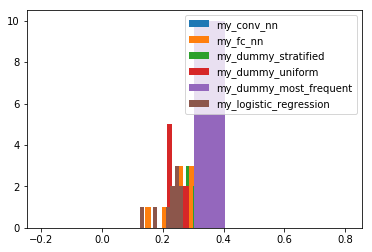

In [52]:
legend_names = []
for model_name, accuracy in accuracies.items():
    plt.hist(accuracy)
    print('{}:\t\t{} +- {}'.format(model_name, np.mean(accuracy), np.std(accuracy)))
    legend_names.append(model_name)
plt.legend(legend_names);

In [ ]:
# Only based on the content with test_fraction = 0.15 and runs = 30:

my_conv_nn:		0.3035714285714285 +- 5.551115123125783e-17
my_fc_nn:		0.25535714285714284 +- 0.04727929391026331
my_dummy_stratified:		0.31071428571428567 +- 0.03499271061118827
my_dummy_uniform:		0.2714285714285714 +- 0.0681385143869247
my_dummy_most_frequent:		0.3035714285714285 +- 5.551115123125783e-17
my_logistic_regression:		0.22678571428571428 +- 0.04229542600831075

my_conv_nn:		0.3035714285714286 +- 5.551115123125783e-17
my_fc_nn:		0.29642857142857143 +- 0.05658206970626735
my_dummy_stratified:		0.25357142857142856 +- 0.05578749768504753
my_dummy_uniform:		0.2720238095238095 +- 0.05526746448305267
my_dummy_most_frequent:		0.3035714285714286 +- 5.551115123125783e-17
my_logistic_regression:		0.3208333333333334 +- 0.0524654351176674


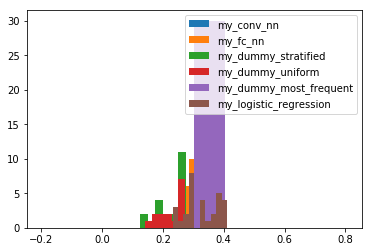

In [16]:
# legend_names = []
# for model_name, accuracy in accuracies.items():
#     plt.hist(accuracy)
#     print('{}:\t\t{} +- {}'.format(model_name, np.mean(accuracy), np.std(accuracy)))
#     legend_names.append(model_name)
# plt.legend(legend_names);

In [ ]:
# Only reply duration adjacency network with test_fraction = 0.15 and runs = 30:

my_conv_nn:		0.3035714285714286 +- 5.551115123125783e-17
my_fc_nn:		0.29642857142857143 +- 0.05658206970626735
my_dummy_stratified:		0.25357142857142856 +- 0.05578749768504753
my_dummy_uniform:		0.2720238095238095 +- 0.05526746448305267
my_dummy_most_frequent:		0.3035714285714286 +- 5.551115123125783e-17
my_logistic_regression:		0.3208333333333334 +- 0.0524654351176674

# Leave one out

In [58]:
with Timer():
    models = [my_logistic_regression, my_dummy_stratified, my_dummy_uniform, my_dummy_most_frequent]
    loo = LeaveOneOut()
    accuracies = defaultdict(list)
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(classification_data['X']):
        X_train, X_test = classification_data['X'][train_index], classification_data['X'][test_index]
        y_train, y_test = classification_data['y'][train_index], classification_data['y'][test_index]
        for model in models:
            accuracies[model.__name__].append(
                model(X_train, X_test, y_train, y_test))

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omid/.local/lib/py

It took 6.97 minutes.


In [65]:
legend_names = []
for model_name, accuracy in accuracies.items():
    print('{}:\t\t{}'.format(model_name, np.sum(accuracy) / len(accuracy)))

my_dummy_uniform:		0.26430517711171664
my_logistic_regression:		0.22070844686648503
my_dummy_most_frequent:		0.3133514986376022
my_dummy_stratified:		0.21525885558583105


In [ ]:
# Only based on the content with leave one out:

my_dummy_uniform:		0.26430517711171664
my_logistic_regression:		0.22070844686648503
my_dummy_most_frequent:		0.3133514986376022
my_dummy_stratified:		0.21525885558583105